In [12]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", duration),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [13]:
true_beta.shape

(372,)

In [14]:
from epymorph.parameter_fitting.dynamics import (
    GeometricBrownianMotion,
)
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_fitting.utils.particle_initializer import ParticleInitializer

In [15]:
from epymorph.parameter_fitting.distribution import Uniform

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    )
}


In [16]:
initializer = ParticleInitializer(100, rume, params_space)
rng = np.random.default_rng(seed=1)
particles = initializer.initialize_particles(rng)

In [ ]:
import dataclasses
from epymorph import initializer
from epymorph.simulator.basic.basic_simulator import BasicSimulator


def propagate_particle(rume, particle, parameters, rng):
    # Create a copy of the RUME model with updated parameters and time frame
    rume_propagate = dataclasses.replace(
        rume,
        # time_frame=TimeFrame.of(date, duration),  # Set simulation duration
        strata=[
            dataclasses.replace(
                g, init=initializer.Explicit(initials=particle.state)
            )  # Initialize with state values
            for g in rume.strata  # For each stratum, set the initial state
        ],
    )

    # Initialize the simulation using the BasicSimulator from the Epymorph library
    sim = BasicSimulator(rume_propagate)

    # Run the simulation and collect the output based on observations
    # (dynamic params)
    output = sim.run(parameters, rng_factory=(lambda: rng))

    return output


In [ ]:
from epymorph.parameter_fitting.utils.params_perturb import Perturb


def propagate_params(parameters, params_space, rng):
    # Update the parameters using their dynamics
    params_perturb = Perturb(1)
    propagated_parameters = []
    for parameter in parameters:
        new_parameters = {}
        for param, val in parameter.items():
            dynamics = params_space[param].dynamics
            if isinstance(dynamics, GeometricBrownianMotion):
                new_parameters[param] = params_perturb.gbm(
                    val, dynamics.volatility, rng
                )
            else:
                new_parameters[param] = val

        propagated_parameters.append(new_parameters)

    return propagated_parameters


In [ ]:
from epymorph.parameter_fitting.utils import utils


def run(particles, rume, params_space, rng, duration):
    # List to store the observation results
    observation_results = []

    # Dictionaries to store quantiles and mean values of each parameter over time
    param_quantiles = {key: [] for key in params_space.keys()}
    param_means = {key: [] for key in params_space.keys()}

    # Initialize particle parameters for the first time step
    particle_params = [particle.parameters for particle in particles]

    # Propagate parameters for each time step
    for t in range(duration):
        # Propagate parameters based on the current state
        propagated_params = propagate_params(particle_params, params_space, rng)

        # Dictionary to temporarily store parameter values for quantiles and means
        temp_key_values = {key: [] for key in param_quantiles.keys()}

        # Collect values for each parameter across all particles
        for param_set in propagated_params:
            for key in temp_key_values:
                if key in param_set:
                    temp_key_values[key].append(param_set[key])

        # Calculate and store the quantiles and means for each parameter
        for key, values in temp_key_values.items():
            if values:
                param_quantiles[key].append(utils.quantiles(np.array(values)))
                param_means[key].append(np.mean(values))

        # Update particle parameters for the next time step
        particle_params = propagated_params

    # After the final time step, create a dictionary of the final mean values of the parameters
    final_param_values = {key: np.array(param_means[key]) for key in param_means}

    # Propagate each particle using the final mean values
    for particle in particles:
        # Apply the model to each particle and collect the results
        result = propagate_particle(rume, particle, final_param_values, rng)
        observation_results.append(result)

    # Return all collected data: observations, final parameters, and quantiles/means of parameters
    return observation_results, final_param_values, param_quantiles, param_means


In [21]:
state_forecast, param_forecast, param_quantiles, param_values = run(
    particles, rume, params_space, rng, duration
)

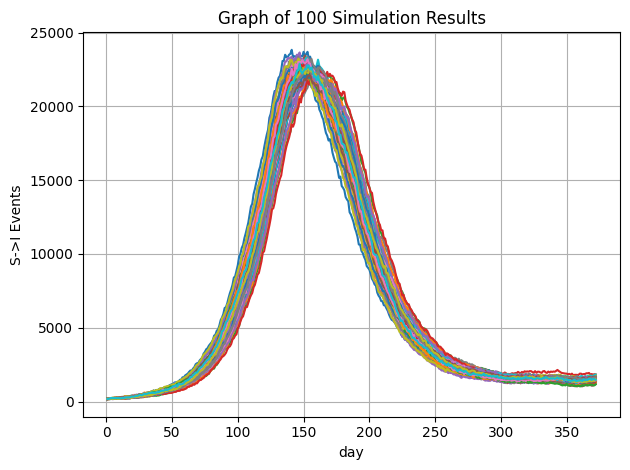

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# This uses the more advanced line_plt() functionality
for j in state_forecast:
    j.plot.line_plt(
        ax=ax,
        geo=j.rume.scope.select.all(),
        time=j.rume.time_frame.select.all(),
        quantity=j.rume.ipm.select.events("S->I"),
    )

ax.set_xlabel("day")
ax.set_ylabel("S->I Events")
ax.set_title("Graph of 100 Simulation Results")
ax.grid(True)

fig.tight_layout()
plt.show()

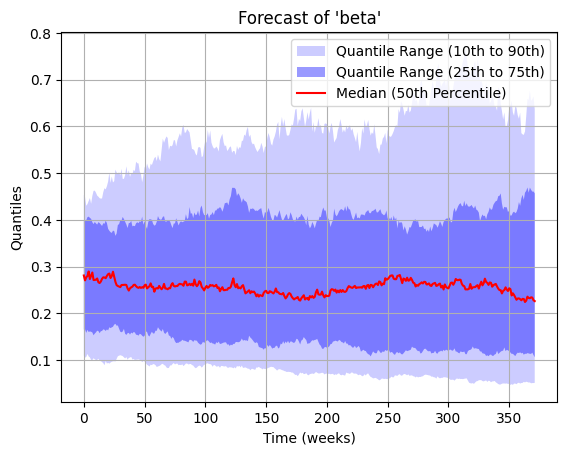

In [23]:
import matplotlib.pyplot as plt

key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)


plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [24]:
param_forecast

{'beta': array([0.28046361, 0.27887219, 0.27892905, 0.28036053, 0.28071153,
        0.28014267, 0.27827749, 0.27936772, 0.27866   , 0.27716506,
        0.27690535, 0.27736645, 0.27715639, 0.27609791, 0.27656297,
        0.27586765, 0.27824471, 0.28035227, 0.28141455, 0.28308772,
        0.28277938, 0.28361634, 0.28182135, 0.28119879, 0.28446746,
        0.28508696, 0.28472564, 0.2841363 , 0.28597771, 0.28603927,
        0.2873507 , 0.28726711, 0.28945907, 0.28911958, 0.28701363,
        0.28741677, 0.28560188, 0.2859522 , 0.28473902, 0.28660407,
        0.28680424, 0.28722848, 0.28698299, 0.28943991, 0.29014296,
        0.28856496, 0.28743884, 0.28542273, 0.28282601, 0.28296859,
        0.28325422, 0.28456214, 0.2860963 , 0.28447287, 0.28553408,
        0.2872192 , 0.28747741, 0.28888988, 0.28977873, 0.2896592 ,
        0.29272273, 0.29252354, 0.2938154 , 0.29311997, 0.29322347,
        0.29510063, 0.29448938, 0.29503657, 0.29540122, 0.29503173,
        0.29561909, 0.29642533, 0.295764

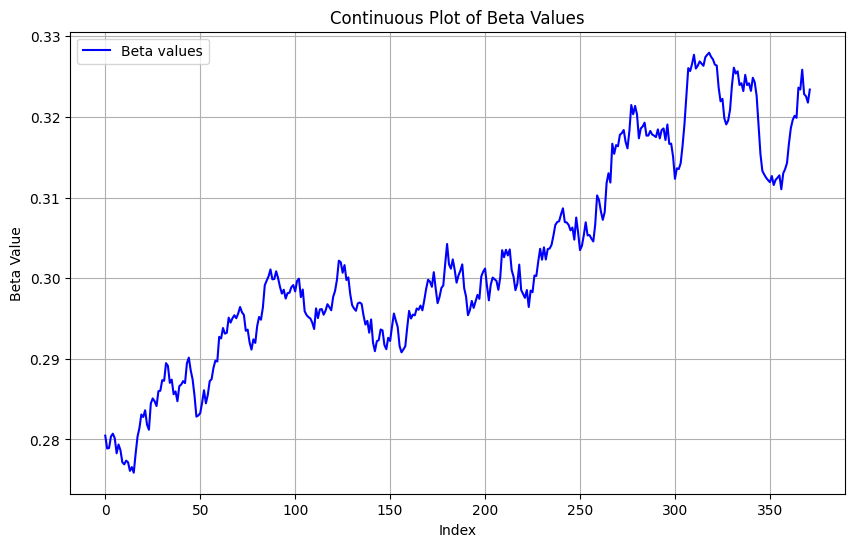

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the beta values
beta_values = param_forecast["beta"]

# Create a continuous plot (single line)
plt.figure(figsize=(10, 6))
plt.plot(beta_values, color="b", label="Beta values")
plt.title("Continuous Plot of Beta Values")
plt.xlabel("Index")
plt.ylabel("Beta Value")
plt.grid(True)
plt.legend()
plt.show()
